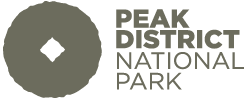

# Creating target 'engagement areas' for school establishments in the Peak District Region

### Introduction
This preliminary analysis, will support evidence for the the Engagement Team and their delivery towards the PDNPA Diverse Audience Plan. This analysis sets out aims to identify shcools that will enable us to work with a more diverse range of groups: 
* targeting local schools who are located in socio-econimically deprived areas, 
* schools with a high level of free school meals (FSM),
* or have higher levels of English as a foreign language (EFL). 

The PDNPA Engagement Service are  developing “new products” beyond our current norm (welcoming school groups to sessions which we lead for them, from a handful of fixed locations in the PDNP) therefore we will focus our delivery and target area on these locations:
* Longdendale Environmental Centre (SK13 1HS)
* Longshaw’s Moorland Discovery Centre (S11 7TZ)
* Macclesfield Forest (SK11 0NS)


This is a reproducible data dictionary based on a python script to scrape open data in order to perform analysis for PDNPA. As this is a script, it can be re-run as and when the data is updated. This analysis is reproducible meaning this analysis can be copied or investigated and improved on. For further details contact;

david.alexander@peakdistrict.gov.uk

### Methodology

1. Create a point file for the fixed locations (engagement centres) above 
2. Create 1 hour drive times for the engagement centres
2. Merge the polygons to create the 'Engagement Schools Target Area'
3. Webscrape the schools establishment data from [gov.uk](https://get-information-schools.service.gov.uk/Downloads)
4. Query the school establishments spatially
5. Plot the information ready for further analysis with the Engagement Team

### Data Engineering

In [79]:
# Manage the GIS
from arcgis import GIS
import arcpy
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
mygis = GIS("Pro")
print(mygis)

GIS @ https://www.arcgis.com/ version:8.3


In [80]:
# setup the environment
arcpy.env.addOutputsToMap = True
arcpy.env.overwriteOutput = True
arcpy.env.workspace = 'C:/Users/alexad/Documents/ArcGIS/Projects/Engagement_Schools_Area/Engagement_Schools_Area.gdb'

##### (1) Create a point .shp file for the Engagement Centres

In [10]:
# create a point array (Longdendale (1) Longshaw (2) Macclesfield Forest (3))
coordinates = [(1, 402819, 397128),
               (2, 426432, 379889),
               (3, 396041, 371259)]

spatial_ref = arcpy.SpatialReference(27700)
pt = arcpy.Point()
ptGeoms = []
for p in coordinates:
    pt.ID = p[0]
    pt.X = p[1]
    pt.Y = p[2]
    ptGeoms.append(arcpy.PointGeometry(pt, spatial_ref))

arcpy.CopyFeatures_management(ptGeoms, r"Engagement_points.shp")

<Result 'C:/Users/alexad/Documents/ArcGIS/Projects/Engagement_Schools_Area\\Engagement_points.shp'>

Lets create a quick map widget to check the data created is OK ;)

1. Publish the shp ***pdnpa/arcgis.com/content***
2. Display on a map widget

In [11]:
Engagement_points_properties = {"title": "Engagement Points",
                               "description": "points of education centres",
                               "tags": "points, engagement",
                               "type": "Shapefile"}

In [13]:
Engagement_points_item = mygis.content.add(Engagement_points_properties, data = r"Engagement_points.zip")

<Item title:"Engagement Points" type:Feature Layer Collection owner:david.alexander_PDNPA>
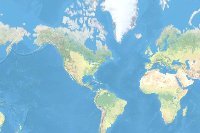

In [22]:
Engagement_points_item = Engagement_points_item.publish()
display(Engagement_points_item)

In [25]:
# take a look :)
Engagement_points_map = mygis.map()
Engagement_points_map.add_layer(Engagement_points_item)
Engagement_points_map.center = [53.3, -1.70]
Engagement_points_map.zoom = 9
Engagement_points_map

MapView(layout=Layout(height='400px', width='100%'))

##### (2) Create hour travel time polygons using the [Generate Service Areas tool](https://pro.arcgis.com/en/pro-app/tool-reference/ready-to-use/itemdesc-generate-service-areas.htm)

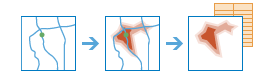

In [35]:
# set the env up for the tool
import sys
import time
sa_service = "https://logistics.arcgis.com/arcgis/services;World/ServiceAreas;{0};{1}".format('user', 'Password')
arcpy.ImportToolbox(sa_service)

<module 'ServiceAreas'>

In [70]:
# set tool variables
Edu_Bases = r"Engagement_points.shp"
Engagement_areas = r"Engagement_Schools_Area.gdb/Engagement_areas_30"

In [71]:
# Call the tool
result = arcpy.GenerateServiceAreas_ServiceAreas(Edu_Bases, "30", "Minutes")
arcpy.AddMessage("Running the analysis with result ID: {}".format(result.resultID))

# Check the status of the result object every 1 second until it has a
# value of 4 (succeeded) or greater
while result.status < 4:
    time.sleep(1)

# print any warning or error messages returned from the tool
result_severity = result.maxSeverity
if result_severity == 2:
    arcpy.AddError("An error occured when running the tool")
    arcpy.AddError(result.getMessages(2))
    sys.exit(2)
elif result_severity == 1:
    arcpy.AddWarning("Warnings were returned when running the tool")
    arcpy.AddWarning(result.getMessages(1))

# Store the output drive time polygons to a geodatabase
result.getOutput(0).save(Engagement_areas)

#### (3) Merge & disolve the polygons to create the 'Engagement Schools Target Area'

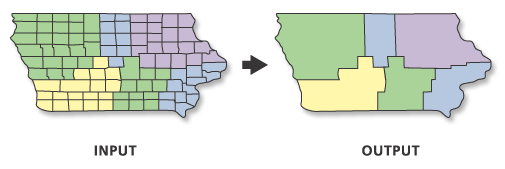

In [93]:
# disolve the 30 min drive time polygons to one area
Target_area = arcpy.Dissolve_management("Engagement_areas_30", "Target_area", ["FromBreak"], "")

Lets create a quick map widget to check the data created is OK ;)

1. Publish the shp ***pdnpa/arcgis.com/content***
2. Display on a map widget

In [94]:
Target_area_properties = {"title": "Target Engagement Area",
                          "description": "areas of 30 mins drive time from education centres",
                          "tags": "polygon, engagement",
                          "type": "Shapefile"}

In [95]:
Target_area_item = mygis.content.add(Target_area_properties, data = r"Target_area.zip")

In [96]:
Target_area_item = Target_area_item.publish()
display(Target_area_item)

<Item title:"Target Engagement Area" type:Feature Layer Collection owner:david.alexander_PDNPA>

In [97]:
# take a look :)
#Engagement_points_map = mygis.map()
Engagement_points_map.add_layer(Target_area_item)
Engagement_points_map

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

##### (4) Webscrape the schools establishment data from gov.uk

In [112]:
# download the Gov.UK data
import io
import requests
url = "https://ea-edubase-api-prod.azurewebsites.net/edubase/downloads/public/edubasealldata20201108.csv"
s = requests.get(url).content
edu_df = pd.read_csv(s)

In [116]:
# import to gis a pandas df
edu_df = gpd.read_file(r"edubasealldata20201108.csv", encoding='latin-1')
# take a look a the first 5 rows
edu_df.head(5)

,URN,LA (code),LA (name),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (code),TypeOfEstablishment (name),EstablishmentTypeGroup (code),EstablishmentTypeGroup (name),EstablishmentStatus (code),EstablishmentStatus (name),ReasonEstablishmentOpened (code),ReasonEstablishmentOpened (name),OpenDate,ReasonEstablishmentClosed (code),ReasonEstablishmentClosed (name),CloseDate,PhaseOfEducation (code),PhaseOfEducation (name),StatutoryLowAge,StatutoryHighAge,Boarders (code),Boarders (name),NurseryProvision (name),OfficialSixthForm (code),OfficialSixthForm (name),Gender (code),Gender (name),ReligiousCharacter (code),ReligiousCharacter (name),ReligiousEthos (name),Diocese (code),Diocese (name),AdmissionsPolicy (code),AdmissionsPolicy (name),SchoolCapacity,SpecialClasses (code),SpecialClasses (name),CensusDate,NumberOfPupils,...,SenUnitOnRoll,SenUnitCapacity,GOR (code),GOR (name),DistrictAdministrative (code),DistrictAdministrative (name),AdministrativeWard (code),AdministrativeWard (name),ParliamentaryConstituency (code),ParliamentaryConstituency (name),UrbanRural (code),UrbanRural (name),GSSLACode (name),Easting,Northing,CensusAreaStatisticWard (name),MSOA (name),LSOA (name),InspectorateName (name),SENStat,SENNoStat,BoardingEstablishment (name),PropsName,PreviousLA (code),PreviousLA (name),PreviousEstablishmentNumber,OfstedRating (name),RSCRegion (name),Country (name),UPRN,SiteName,QABName (code),QABName (name),EstablishmentAccredited (code),EstablishmentAccredited (name),QABReport,CHNumber,MSOA (code),LSOA (code),geometry
0,100000,201,City of London,3614,The Aldgate School,2,Voluntary aided school,4,Local authority maintained schools,1,Open,0,Not applicable,,0,Not applicable,,2,Primary,3,11,1,No boarders,Has Nursery Classes,2,Does not have a sixth form,3,Mixed,2,Church of England,Does not apply,CE23,Diocese of London,0,Not applicable,293,2,No Special Classes,16/01/2020,276,...,,,H,London,E09000001,City of London,E05009308,Portsoken,E14000639,Cities of London and Westminster,A1,(England/Wales) Urban major conurbation,E09000001,533498,181201,,City of London 001,City of London 001F,,,,,,999,,,Outstanding,North-West London and South-Central England,,2E+11,,0,Not applicable,0,Not applicable,,,E02000001,E01032739,None
1,100001,201,City of London,6005,City of London School for Girls,11,Other independent school,3,Independent schools,1,Open,0,Not applicable,01/01/1920,0,Not applicable,,0,Not applicable,7,18,1,No boarders,No Nursery Classes,1,Has a sixth form,2,Girls,6,None,Christian/non-denominational,0,Not applicable,0,Not applicable,780,2,No Special Classes,16/01/2020,744,...,,,H,London,E09000001,City of London,E05009302,Cripplegate,E14000639,Cities of London and Westminster,A1,(England/Wales) Urban major conurbation,E09000001,532301,181746,,City of London 001,City of London 001B,ISI,0,63,Does not have boarders,Corporation of London,999,,,,North-West London and South-Central England,,2E+11,,0,Not applicable,0,Not applicable,,,E02000001,E01000002,None
2,100002,201,City of London,6006,St Paul's Cathedral School,11,Other independent school,3,Independent schools,1,Open,0,Not applicable,01/01/1939,0,Not applicable,,0,Not applicable,4,13,3,Boarding school,No Nursery Classes,2,Does not have a sixth form,3,Mixed,2,Church of England,Christian,0,Not applicable,0,Not applicable,265,2,No Special Classes,16/01/2020,260,...,,,H,London,E09000001,City of London,E05009293,Bread Street,E14000639,Cities of London and Westminster,A1,(England/Wales) Urban major conurbation,E09000001,532160,181151,,City of London 001,City of London 001F,ISI,0,21,Has boarders,,999,,,,North-West London and South-Central England,,2E+11,,0,Not applicable,0,Not applicable,,,E02000001,E01032739,None
3,100003,201,City of London,6007,City of London School,11,Other independent school,3,Independent schools,1,Open,0,Not applicable,01/01/1919,0,Not applicable,,0,Not applicable,10,18,1,No boarders,No Nursery Classes,1,Has a sixth form,1,Boys,6,None,None,0,Not applicable,0,Not applicab

##### (5) Query the school establishments spatially

1. Clip the data by the target area


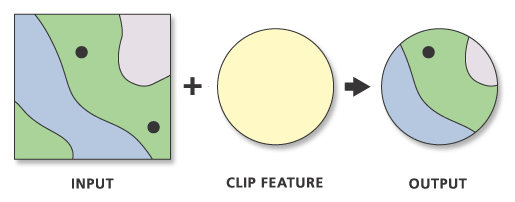


In [135]:
# lets change the Target area to geopandas to clip as a df
target_area_df = gpd.read_file(r"Target_area.shp", crs=27700)
# lets clip
edu_df_clipped = gpd.clip(edu_df, target_area_df)
